In [3]:
# Matteo Chinellato matricola 0322500038
# Elaborato per corso Apprendimento Automatico e Apprendimento Profondo (Professoressa Scarpato)
# Il dataset scelto è "Early Stage Diabetes Risk Prediction"
# 17 features (di cui 1 target), tutte binarie tranne l'età che è ordinabile
# numero di righe contenuto
# lavoro nella sanità pubblica e il tema è affine

# import librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve)
from sklearn.model_selection import cross_val_score

In [4]:
# Import del dataset
df = pd.read_csv('diabetes_data_upload.csv')

# utilizzo Label Encoding per la codifica delle variabili categoriche (ecetto l'età sono tutte testuali ma binarie)
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = le.fit_transform(df_encoded[col])

# distinguo il traget "class" (ultima colonna) dalle feature
X = df_encoded.drop('class', axis=1) #seleziono tutto il dataset tranne la colonna "class"
y = df_encoded['class']

# suddivido il dataset in training (70%), validation (15%) e test (15%)
# le percentuali scelte sono dovute al numerto limitato di righe del dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# effettuo lo scaling per evitare che la feature età domini le altre
scaler = StandardScaler()
# effettuo lo scaling speratamente su Traning, Validation e Test set 
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# effettuo anche lo scaling globale per la visualizzazione PCA
X_scaled_full = scaler.fit_transform(X)

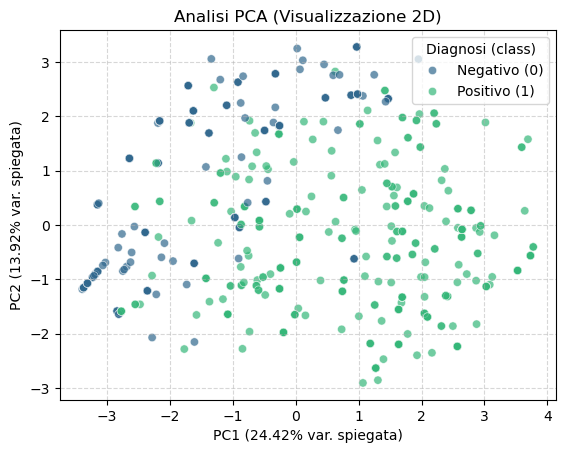

In [5]:
# --------------------------------------------------------------------------
# 1. Analisi delle feature del dataset scelto mediante l’implementazione 
# dell’algoritmo PCA per le feature scelte e visualizzazione dei risultati
# --------------------------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_full)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y.values

# creo il grafico
ax = sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='viridis', alpha=0.7)
# modifico la legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Negativo (0)', 'Positivo (1)'], title='Diagnosi (class)')
# modifico titolo e nome degli assi
plt.title('Analisi PCA (Visualizzazione 2D)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var. spiegata)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var. spiegata)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('analisi_pca.png')
plt.show()

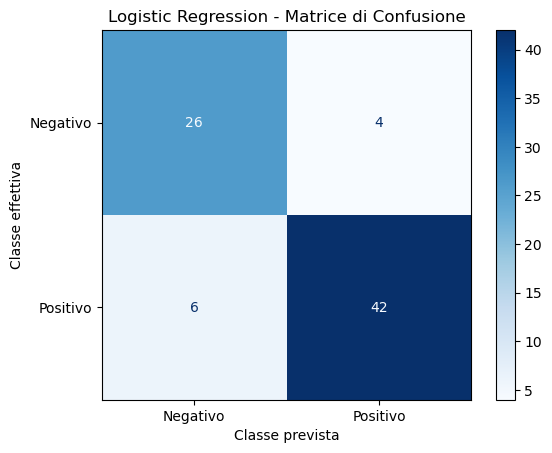

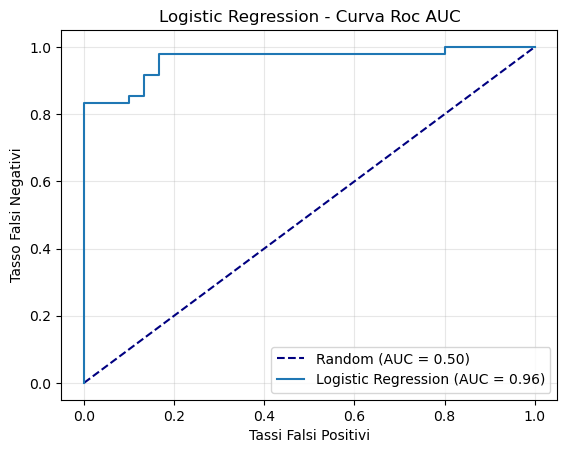

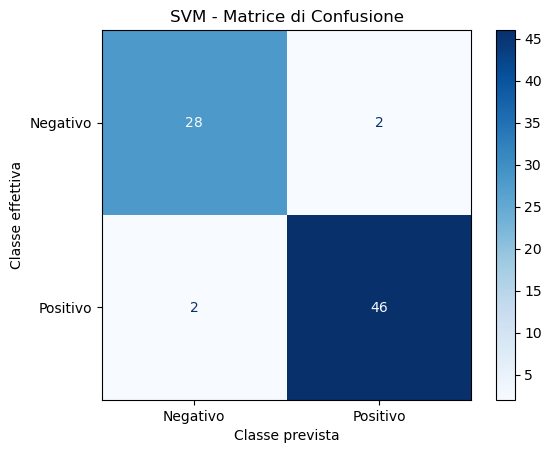

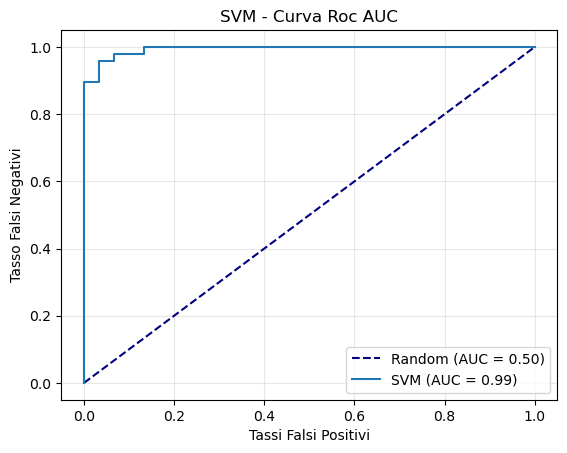

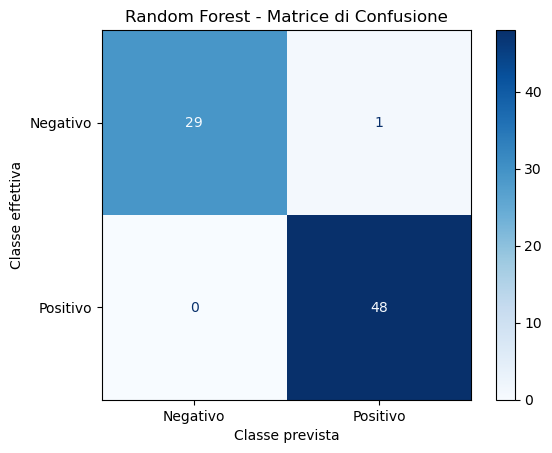

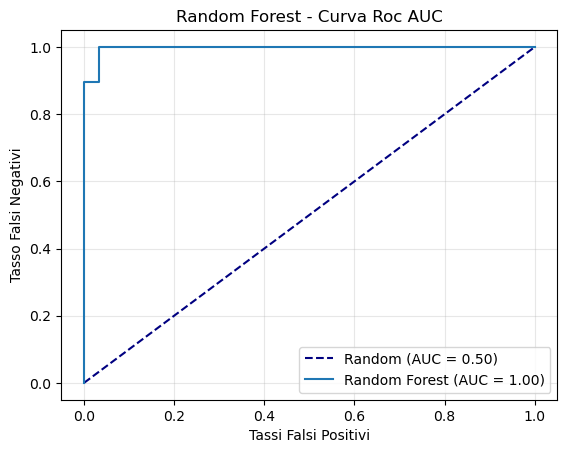

In [6]:
# ----------------------------------------------------------------------------------------
# 2. Implementazione di almeno tre degli algoritmi di classificazione affrontati nel corso
# ----------------------------------------------------------------------------------------
# definisco gli algoritmi di classificazione che voglio utilizzare
models = {
    "Logistic Regression": LogisticRegression(random_state=42), # modello lineare, non idoneo 
    "SVM": SVC(probability=True, random_state=42), # specifico per le zone di sovrapposizione, idoneo 
    "Random Forest": RandomForestClassifier(random_state=42) # struttura ad albero, particolarmente idoneo
}

results_list = [] # preparo la struttura dati per memorarizzare i dati dei tre modelli 

# ciclo le operazioni sui tre modelli
for name, model in models.items():

    # eseguo la cross validation su 5 fold
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # addestro i modelli esclusivamente sul Training Set Scalato
    model.fit(X_train_scaled, y_train)    
    # verifico se il modello sta imparando bene senza andare in overfitting
    y_val_pred = model.predict(X_val_scaled)
    # chiedo ai modelli addestrati di effettuare la previsione sul Test Set Scalato
    y_pred = model.predict(X_test_scaled)
    # chiedo ai modelli addestrati di determinare la probabilità 
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # ------------------------------------------------------------------------------------------------------------
    # 3. Implementazione del calcolo delle metriche di valutazione precision, recall, f-measure, accuracy, Roc AUC
    # ------------------------------------------------------------------------------------------------------------
    metrics = {
        "Modello": name,
        # Media dell'accuratezza sui 5 fold della cross-validation su training set 
        "Accuracy_Cross_Validation": cv_scores.mean(),
         # percentuale di previsioni corrette sul totale dei casi su validation set
        "Accuracy_Validation_set": accuracy_score(y_val, y_val_pred),
         # percentuale di previsioni corrette sul totale dei casi su test set
        "Accuracy_Test_set": accuracy_score(y_test, y_pred),
        # capacità del modello di evitare falsi positivi
        "Precision_Test_set": precision_score(y_test, y_pred), 
         # capacità del modello di evitare falsi negativi
        "Recall_Test_set": recall_score(y_test, y_pred),
         # media armonica tra precision e recall 
        "F1-measure_Test_set": f1_score(y_test, y_pred),
         # capacità del modello di distinguere le due classi
        "ROC_AUC_Test_set": roc_auc_score(y_test, y_proba)
    }
    results_list.append(metrics)
    
    # ------------------------------------------------------------------------------------------
    # 4. Implementazione della visualizzazione della matrice di confusione e della ROC AUC Curve
    # ------------------------------------------------------------------------------------------
     # calcolo i dati per disegnare la matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    # disegno la matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negativo', 'Positivo'])
    disp.plot(cmap='Blues')
    plt.title(f'{name} - Matrice di Confusione')
    plt.xlabel('Classe prevista')
    plt.ylabel('Classe effettiva')
    plt.savefig(f'matrice_confusione_{name.lower().replace(" ", "_")}.png')
    plt.show()

    # calcolo i dati necessari per disegnare la curva Roc AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # disegno la curva Roc AUC
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (AUC = 0.50)')
    plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["ROC_AUC_Test_set"]:.2f})')
    plt.title(f'{name} - Curva Roc AUC')
    plt.xlabel('Tassi Falsi Positivi')
    plt.ylabel('Tasso Falsi Negativi')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f'curva_Roc_AUC_{name.lower().replace(" ", "_")}.png')
    plt.show()
# fine ciclo

In [7]:
# stampo in formato tabellare il riepilogo delle metriche rilevate sui modelli evidenziando i risultati migliori
metrics_summary = pd.DataFrame(results_list)
print("\n ----- Confronto riassuntivo Metriche di Valutazione ----- ")
styled_results = metrics_summary.style.highlight_max( #evidenzio il valori massimi per ciascuna colonna
    subset=metrics_summary.columns[1:], # salto la colonna Modello altrimenti mi evidenzia SVM
    color='lightgreen', # colore verde chiaro
    axis=0 # identifica il valore massimo
).hide(axis='index')
display(styled_results)


 ----- Confronto riassuntivo Metriche di Valutazione ----- 


Modello,Accuracy_Cross_Validation,Accuracy_Validation_set,Accuracy_Test_set,Precision_Test_set,Recall_Test_set,F1-measure_Test_set,ROC_AUC_Test_set
Logistic Regression,0.922907,0.974359,0.871795,0.913043,0.875000,0.893617,0.962500
SVM,0.961492,0.974359,0.948718,0.958333,0.958333,0.958333,0.993750
Random Forest,0.967047,0.987179,0.987179,0.979592,1.000000,0.989691,0.996528


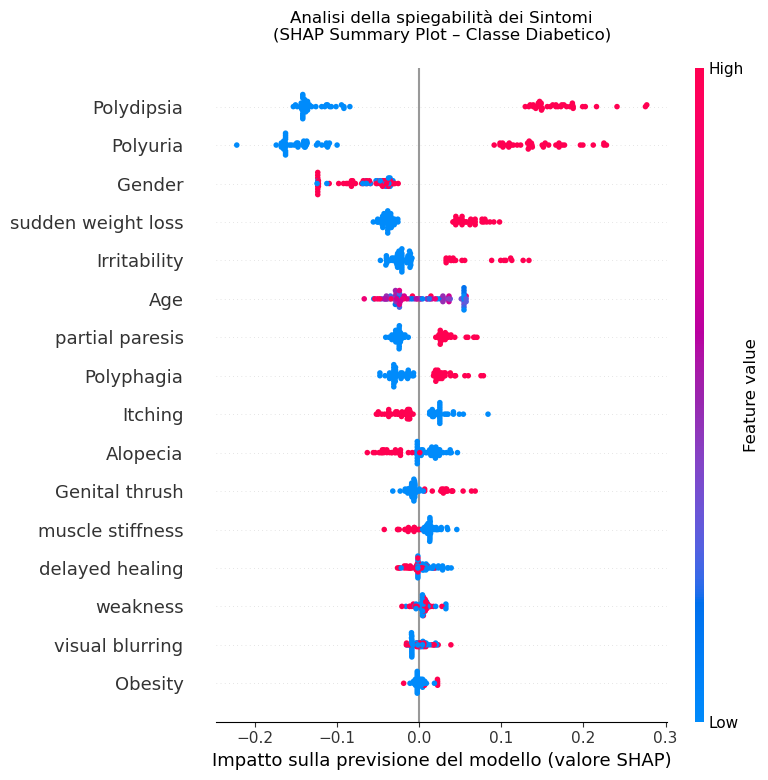

In [8]:
# ------------------------------------------------------------------------------------------
# 5. Implementazione approccio di spiegabilità SHAP
# ------------------------------------------------------------------------------------------
plt.close('all') # pulizia ambiente grafico per ottenre una corretta rappresentazione del summary plot

X_test_df = pd.DataFrame(X_test, columns=X.columns) # utilizzo il dataframe NON scalato
explainer = shap.TreeExplainer(models["Random Forest"]) # creazione explainer su random forest
shap_values = explainer.shap_values(X_test_df) # calcolo SHAP values

if isinstance(shap_values, list): # verifico il tipo di risultato per capirre come estrare i valori legazi ai pazienti positivi 
    val_to_plot = shap_values[1] # in caso di risultato tipo lista, ovvereo SHAP <= 0.40
else:
    val_to_plot = shap_values[:, :, 1] # in caso di risultato tipo array 3D, ovvero SHAP >= 0.41

# creazione Summary Plot
shap.summary_plot(
    val_to_plot,
    X_test_df,
    plot_type="dot",
    max_display=X_test_df.shape[1],
    show=False
)
# titolo
plt.title(
    "Analisi della spiegabilità dei Sintomi\n(SHAP Summary Plot – Classe Diabetico)",
    pad=20
)
# label ordinate
plt.xlabel(
    "Impatto sulla previsione del modello (valore SHAP)",
)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.show()